+--------+---+------+----------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+----------+-------------+--------------+----+----+---+

['FTHG', 'FTAG', 'FTR']
[('FTHG', 'HomeTeamGoals'), ('FTAG', 'AwayTeamGoals'), ('FTR', 'FinalResult')]
+--------+---+------+----------+------------------+--------------+-------------+-------------+-----------+
|Match_ID|Div|Season|      Date|          HomeTeam|      AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult

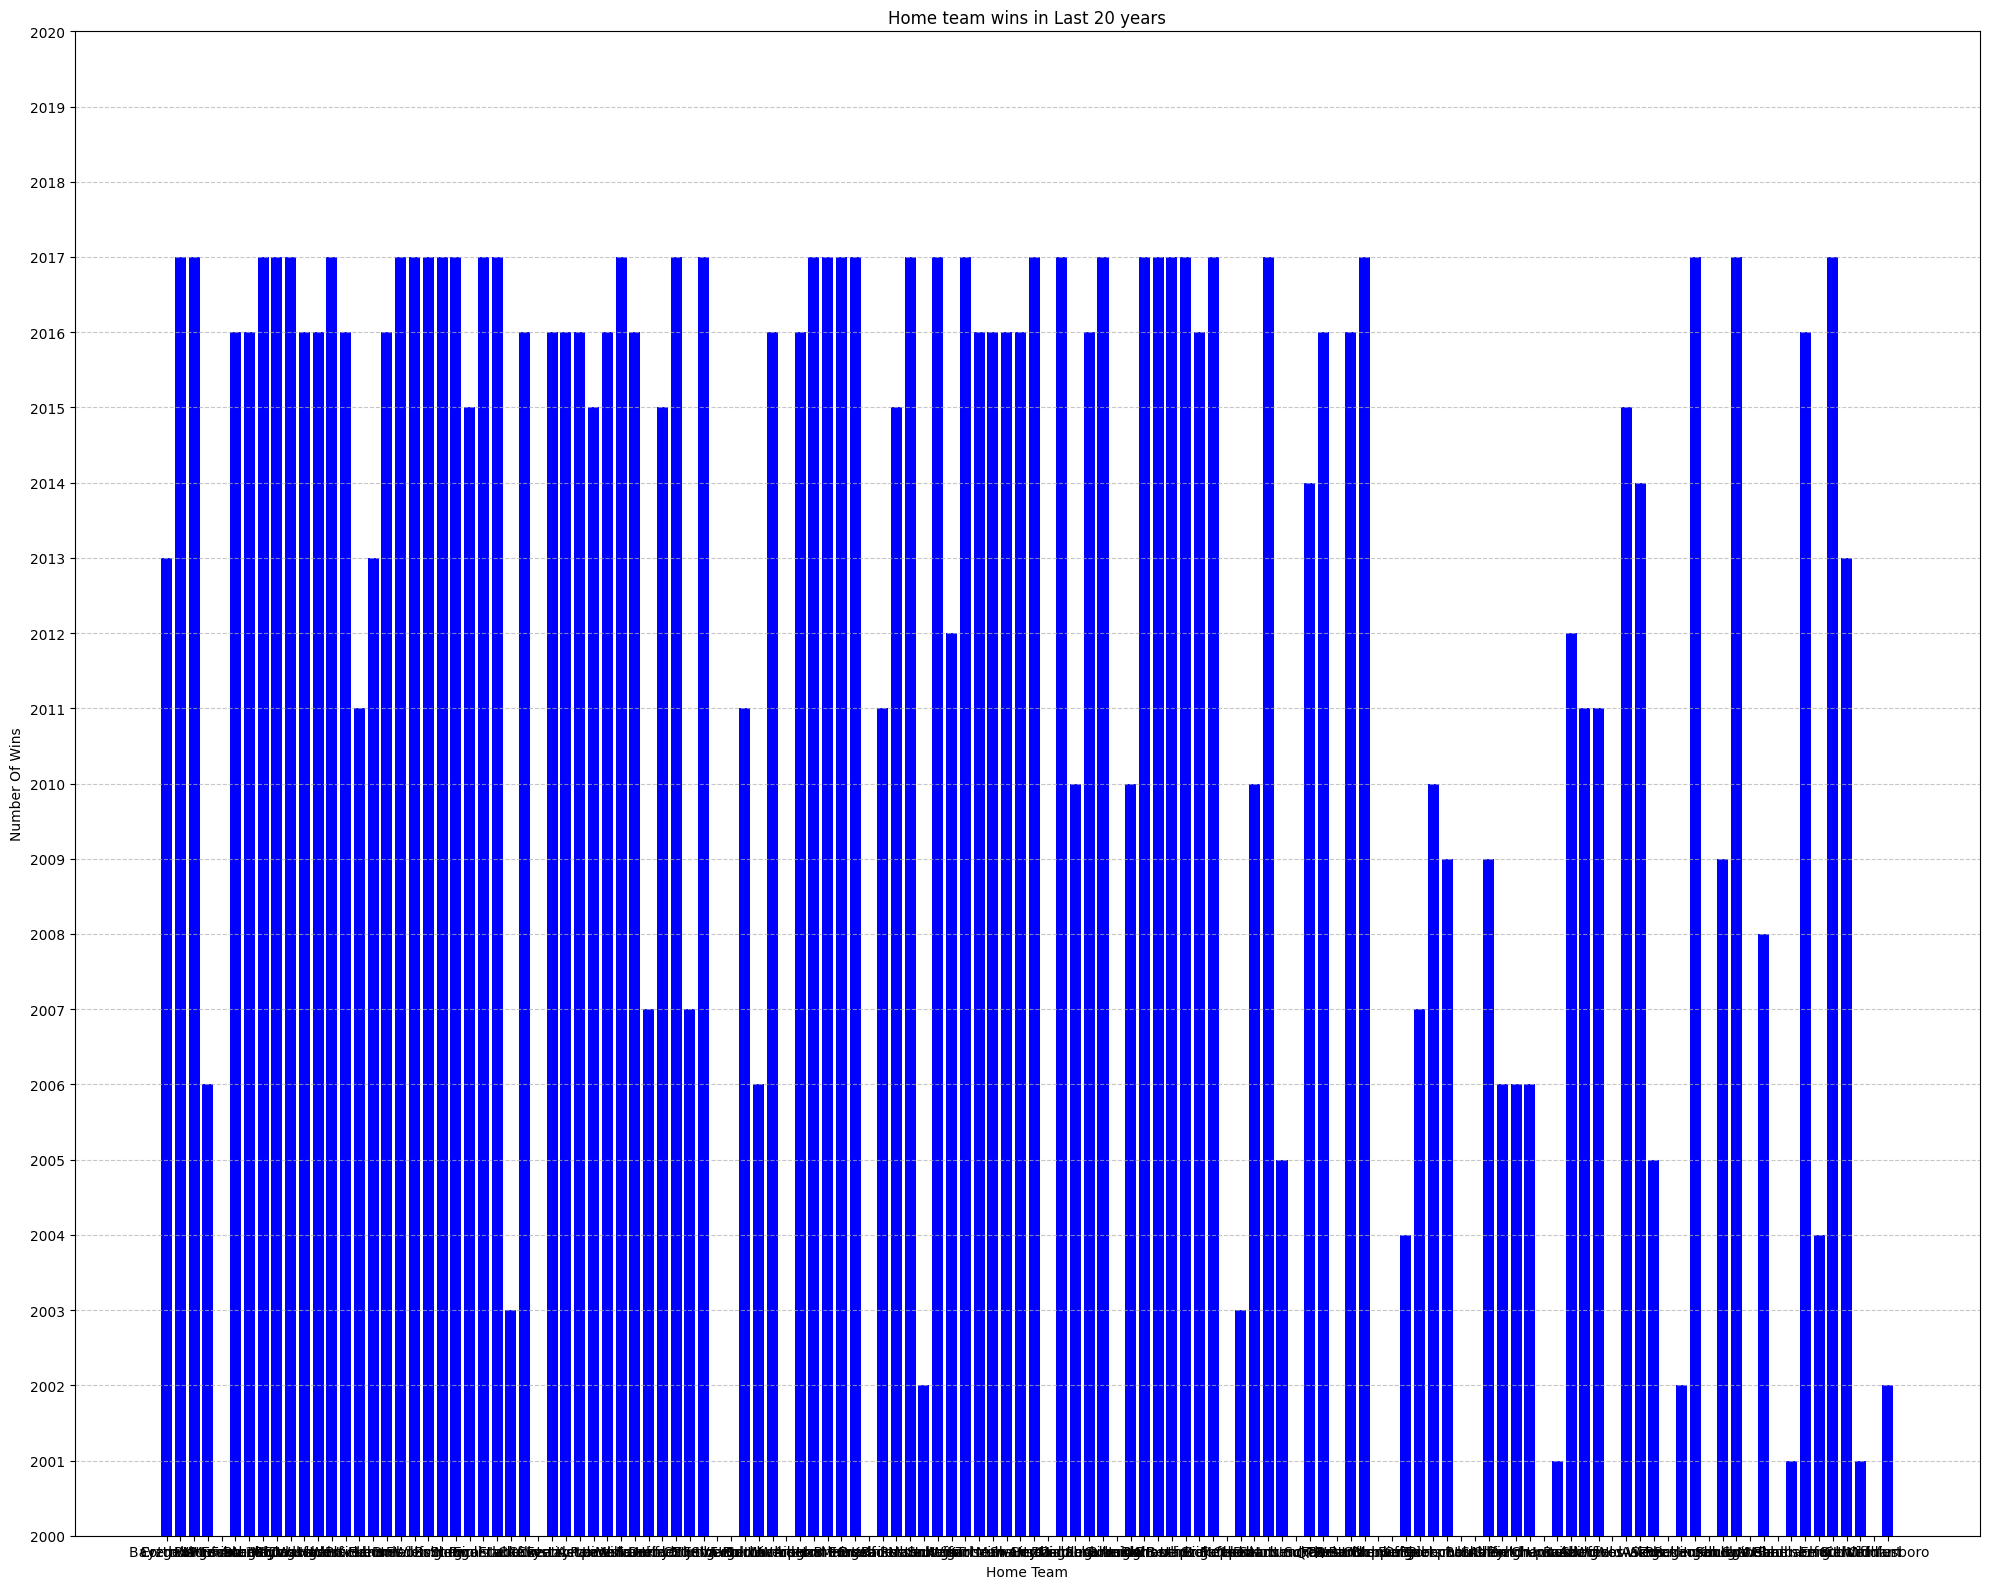

+--------+---+------+----------+-------------+----------+-------------+-------------+-----------+-----------+-----------+-------+
|Match_ID|Div|Season|      Date|     HomeTeam|  AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|HomeTeamWin|AwayTeamWin|GameTie|
+--------+---+------+----------+-------------+----------+-------------+-------------+-----------+-----------+-----------+-------+
|      21| D1|  2009|2010-02-06|       Bochum|Leverkusen|            1|            1|          D|          0|          0|      1|
|      22| D1|  2009|2009-11-22|Bayern Munich|Leverkusen|            1|            1|          D|          0|          0|      1|
|      23| D1|  2009|2010-05-08|   M'gladbach|Leverkusen|            1|            1|          D|          0|          0|      1|
|      24| D1|  2009|2009-08-08|        Mainz|Leverkusen|            2|            2|          D|          0|          0|      1|
|      25| D1|  2009|2009-10-17|      Hamburg|Leverkusen|            0|            0|     

,Team,Season,GoalDifferential,Wins,Loss,Tie,WinPct,TeamPosition
0,Bayern Munich,2000,25,19,9,6,55.88,1
1,Leverkusen,2001,39,21,7,6,61.76,1
2,Bayern Munich,2002,45,23,5,6,67.65,1
3,Werder Bremen,2003,41,22,4,8,64.71,1
4,Bayern Munich,2004,42,24,5,5,70.59,1
5,Bayern Munich,2005,35,22,3,9,64.71,1
6,Stuttgart,2006,24,21,6,7,61.76,1
7,Bayern Munich,2007,47,22,2,10,64.71,1
8,Wolfsburg,2008,39,21,7,6,61.76,1
9,Bayern Munich,2009,41,20,4,10,58.82,1


In [2]:

import findspark
import requests
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt


spark = SparkSession.builder.appName("FOotball_Analysis").getOrCreate()


def download_file(url,local_path):
    response = requests.get(url)
    response.raise_for_status
    with open(local_path,'wb') as file:
        file.write(response.content)
url = "https://raw.githubusercontent.com/henokyemam/Wrangling_PySpark/main/Data/Matches.csv"
local_path = "/home/rahul/git_data/Wrangling_PySpark/Data/Matches.csv"
download_file(url,local_path)

    
    
    


def read_file(local_path):
    
    df = spark.read.csv(local_path, header=True, inferSchema=True)
    return df
df_matches = read_file(local_path)
df_matches.limit(5).show()


old_cols = df_matches.columns[-3:]
print(old_cols)
new_cols = ["HomeTeamGoals", "AwayTeamGoals", "FinalResult"]
old_new_cols = [*zip(old_cols,new_cols)]
print(old_new_cols)
for old_col, new_col in old_new_cols:
    df_matches=df_matches.withColumnRenamed(old_col,new_col)
df_matches.show()

print("hello world")
    


df_matches = df_matches.withColumn('HomeTeamWin',when(col('FinalREsult')=='H',1).otherwise(0))\
                        .withColumn('AwayTeamWin',when(col('FinalREsult')=='A',1).otherwise(0))\
                        .withColumn('GameTie',when(col('FinalREsult')=='D',1).otherwise(0))
df_matches.show()


gdf = df_matches.groupBy('Season','HomeTeam').agg(sum('HomeTeamWin').alias('TotalHOmeWIns'))
gdf.show()
gdf.limit(20)
gdf = gdf.toPandas()

from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(20, 16))


plt.bar(gdf['HomeTeam'], gdf['Season'], color='blue')

plt.xlabel("Home Team")
plt.ylabel("Number Of Wins")
plt.title("Home team wins in Last 20 years")


plt.ylim(2000, 2020)
y_int = MultipleLocator(1)
plt.gca().yaxis.set_major_locator(y_int)


plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()


plt.show()



bundesliga = df_matches.filter((col('Season') >= 2000) & (col('Season') <= 2010) & (col('Div') == 'D1'))
bundesliga.show()



home = bundesliga.groupBy('Season','HomeTeam')\
                        .agg(sum('HomeTeamWin').alias('TotalHomeWIn')\
                            ,sum('AwayTeamWin').alias('TotalHomeLoss')\
                            ,sum('GameTie').alias('TotalHomeTie')\
                            ,sum('HomeTeamGoals').alias('HomeScoredGoals')\
                            ,sum('AwayTeamGoals').alias('HomeAgainstGoals'))\
                        .withColumnRenamed('HomeTeam','Team')



home.show()


away = bundesliga.groupBy('Season','AwayTeam')\
                        .agg(sum('AwayTeamWin').alias('TotalAwayWIn')\
                            ,sum('HomeTeamWin').alias('TotalAwayLoss')\
                            ,sum('GameTie').alias('TotalAWayTie')\
                            ,sum('AwayTeamGoals').alias('AwayScoredGoals')\
                            ,sum('HomeTeamGoals').alias('AwayAgainstGoals'))\
                        .withColumnRenamed('AwayTeam','Team')
away.show()


from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, sum, rank, round, asc


window = Window.partitionBy('Season').orderBy(col('WinPct').desc(), col('GoalDifferential').desc())


table = home.join(away, ['Team', 'Season'], 'inner') \
    .withColumn('TotalScoredGoals', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('TotalAgainstGoals', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDifferential', col('TotalScoredGoals') - col('TotalAgainstGoals')) \
    .withColumn('Wins', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Tie', col('TotalHomeTie') + col('TotalAwayTie')) \
    .withColumn('WinPct', round(100 * (col('Wins') / (col('Wins') + col('Loss') + col('Tie'))), 2)) \
    .drop('HomeScoredGoals', 'AwayScoredGoals', 'HomeAgainstGoals', 'AwayAgainstGoals', 'TotalScoredGoals', 'TotalAgainstGoals') \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss', 'TotalHomeTie', 'TotalAwayTie') \
    .withColumn('TeamPosition', rank().over(window))


table_df = table.filter(col('TeamPosition') == 1).orderBy(asc('Season')).toPandas()
table_df


